In [ ]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d sobhanmoosavi/us-accidents
# !unzip us-accidents.zip

In [ ]:
# !git clone https://github.com/rapidsai/rapidsai-csp-utils.git
# !python rapidsai-csp-utils/colab/pip-install.py

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tabulate import tabulate
import cudf
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

In [ ]:
df=cudf.read_csv("US_Accidents_March23.csv")

In [ ]:
df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 46 columns):
 #   Column                 Dtype
---  ------                 -----
 0   ID                     object
 1   Source                 object
 2   Severity               int64
 3   Start_Time             object
 4   End_Time               object
 5   Start_Lat              float64
 6   Start_Lng              float64
 7   End_Lat                float64
 8   End_Lng                float64
 9   Distance(mi)           float64
 10  Description            object
 11  Street                 object
 12  City                   object
 13  County                 object
 14  State                  object
 15  Zipcode                object
 16  Country                object
 17  Timezone               object
 18  Airport_Code           object
 19  Weather_Timestamp      object
 20  Temperature(F)         float64
 21  Wind_Chill(F)          float64
 22  Humidity(%)            float64
 23  

In [ ]:
df.drop(columns=["ID", "Description", "Country","Source","Timezone"], inplace=True)

In [ ]:
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(0)
df['End_Lat'] = df['End_Lat'].fillna(df['Start_Lat'])
df['End_Lng'] = df['End_Lng'].fillna(df['Start_Lng'])
df['Precipitation(in)'] = df['Precipitation(in)'].fillna(0)
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].fillna(df['Wind_Speed(mph)'].median())
df['Pressure(in)'] = df['Pressure(in)'].fillna(df['Pressure(in)'].median())
df['Visibility(mi)'] = df['Visibility(mi)'].fillna(df['Visibility(mi)'].median())
df['Weather_Timestamp'] = df['Weather_Timestamp'].fillna(df['Start_Time'])
df['Zipcode'] = df['Zipcode'].fillna("00000")
df['Humidity(%)'] = df['Humidity(%)'].fillna(df['Humidity(%)'].median())

In [ ]:
text_columns = [
    "City", "State", "Weather_Condition","Street",
    "Wind_Direction", "Sunrise_Sunset", "Civil_Twilight",
    "Nautical_Twilight", "Astronomical_Twilight","County"
]

for c in text_columns:
    encoder = LabelEncoder()
    encoded = encoder.fit_transform(df[c].to_pandas().astype(str))
    df[c] = cudf.Series(encoded).astype("uint16")

In [ ]:
df["Airport_Code"] = cudf.Series(encoder.fit_transform(df["Airport_Code"].to_pandas())).astype("uint8")

df['Humidity(%)'] = df['Humidity(%)'].astype('uint8')
df['Temperature(F)'] = df['Temperature(F)'].astype('int16')
df['Wind_Chill(F)'] = df['Wind_Chill(F)'].astype('int8')
df['Visibility(mi)'] = df['Visibility(mi)'].astype('int16')
df['Wind_Speed(mph)'] = df['Wind_Speed(mph)'].astype('int16')

In [ ]:
cols = ["Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit",
        "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming",
        "Traffic_Signal", "Turning_Loop","Humidity(%)","Temperature(F)"]

for col in cols:
    df[col] = df[col].astype("uint8")

df['Temperature(F)'] = df['Temperature(F)'].fillna(df['Temperature(F)'].median())
df['Wind_Chill(F)'] = df['Wind_Chill(F)'].fillna(df['Wind_Chill(F)'].median())


In [ ]:
float_cols = ["Distance(mi)", "Pressure(in)", "Precipitation(in)"]

for col in float_cols:
    df[col] = df[col].round(1).astype("float32")


In [ ]:
def auto_data_type(df):
    for col in df.select_dtypes(include=[np.number]).columns:
        min_value = df[col].min()
        max_value = df[col].max()

        if pd.api.types.is_float_dtype(df[col]):
            df[col] = df[col].astype(np.float32)
        elif min_value >= 0:
            if max_value <= 255:
                df[col] = df[col].astype(np.uint8)
            elif max_value <= 65535:
                df[col] = df[col].astype(np.uint16)
            elif max_value <= 4294967295:
                df[col] = df[col].astype(np.uint32)
            else:
                df[col] = df[col].astype(np.uint64)
        else:
            if -128 <= min_value and max_value <= 127:
                df[col] = df[col].astype(np.int8)
            elif -32768 <= min_value and max_value <= 32767:
                df[col] = df[col].astype(np.int16)
            elif -2147483648 <= min_value and max_value <= 2147483647:
                df[col] = df[col].astype(np.int32)
            else:
                df[col] = df[col].astype(np.int64)
    return df


converted_df=auto_data_type(df)

In [ ]:
converted_df.info()

<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 7728394 entries, 0 to 7728393
Data columns (total 41 columns):
 #   Column                 Dtype
---  ------                 -----
 0   Severity               uint8
 1   Start_Time             object
 2   End_Time               object
 3   Start_Lat              float32
 4   Start_Lng              float32
 5   End_Lat                float32
 6   End_Lng                float32
 7   Distance(mi)           float32
 8   Street                 uint16
 9   City                   uint16
 10  County                 uint16
 11  State                  uint8
 12  Zipcode                object
 13  Airport_Code           uint8
 14  Weather_Timestamp      object
 15  Temperature(F)         uint8
 16  Wind_Chill(F)          int8
 17  Humidity(%)            uint8
 18  Pressure(in)           float32
 19  Visibility(mi)         uint8
 20  Wind_Direction         uint8
 21  Wind_Speed(mph)        uint16
 22  Precipitation(in)      float32
 23  Weather_C

In [ ]:
df = converted_df.copy()

time_cols = ['Start_Time', 'End_Time', 'Weather_Timestamp']

for col in time_cols:
    if col in df.columns:
        ps = df[col].astype('str').to_pandas()
        ps_dt = pd.to_datetime(ps, errors='coerce')

        gs_dt = cudf.Series(ps_dt)

        prefix = col.replace('_Timestamp', '').replace('_Time', '')
        df[f'{prefix}_Year']    = gs_dt.dt.year
        df[f'{prefix}_Month']   = gs_dt.dt.month
        df[f'{prefix}_Day']     = gs_dt.dt.day
        df[f'{prefix}_Hour']    = gs_dt.dt.hour
        df[f'{prefix}_Weekday'] = gs_dt.dt.weekday

if 'Zipcode' in df.columns:
    ps_zip = df['Zipcode'].astype('str').to_pandas().str.extract(r'(\d+)')[0]
    ps_zip = pd.to_numeric(ps_zip, errors='coerce').fillna(0).astype('int32')
    df['Zipcode_num'] = cudf.Series(ps_zip)

In [ ]:
df_pd = df.to_pandas()

y = df_pd['Severity']- 1

num_cols = [c for c in df_pd.columns if pd.api.types.is_numeric_dtype(df_pd[c])]
X = df_pd[num_cols].drop(columns=['Severity'])


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [ ]:
class_weights = { 0: 15, 1: 0.5, 2: 1,3: 5}

sample_weights = y_train.map(class_weights).astype('float32')

model = xgb.XGBClassifier(
    device='cuda',
    learning_rate=0.05,
    n_estimators=500,
    max_depth=6,
    reg_lambda=10,
)


model.fit(x_train, y_train)
y_pred = model.predict(x_test)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.43      0.54     13473
           1       0.90      0.96      0.93   1231396
           2       0.77      0.60      0.67    259868
           3       0.66      0.17      0.27     40942

    accuracy                           0.88   1545679
   macro avg       0.76      0.54      0.60   1545679
weighted avg       0.87      0.88      0.86   1545679



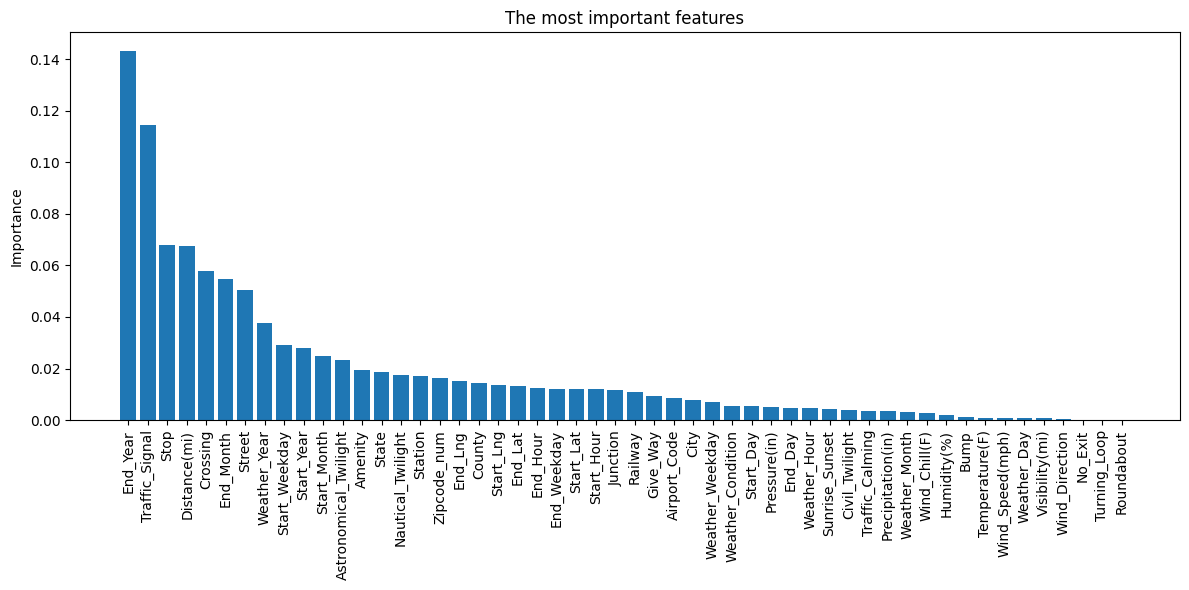

In [63]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(12, 6))
plt.title("The most important features")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), feature_names[indices], rotation=90)
plt.ylabel("Importance")
plt.tight_layout()
plt.show()